In [1]:
#import scipy.sparse as sps
from sklearn.linear_model import LogisticRegression	
#from keras.models import Sequential
#from keras.layers import Dense
import scipy.io
import numpy as np
from scipy import linalg as LA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#from keras import optimizers
import xgboost as xgb
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import pywt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Feature extraction using Wavelet transform
Feature matrix:
Computing relative energy of the coefficients as fetures for the classification. Computed 2 levels of wavelet coefficients and their respective energies. Used a Debauchis 4 wavelet. 

Every data point will have $#channels * #wavelet_coefficients$

Relative energy formula taken from paper titled :
*Feature extraction and classification for EEG signals using wavelet transform and machine learning techniques*


In [3]:
def feature_mat(data,time):
    for data_channel in range(data.shape[1]):
        var=0
        feat=[]
        data_tmp=data[:,data_channel]
        for time_count in time[0]:
            temp_coeff=pywt.wavedec(data_tmp[var:time_count],'db4',level=2)
            A2,D2,D1=temp_coeff
            ED=np.zeros(2)
            ED[0]=sum(D1**2)
            ED[1]=sum(D2**2)
            EA=sum(A2**2)
            Etotal=sum(ED)+EA    
            ED_norm=ED/Etotal
            EA_norm=EA/Etotal
            tmp_feat_1=np.append(EA_norm,ED_norm[0:2])
            feat.append(tmp_feat_1)
            var=time_count
        feat_arr=np.array(feat)
        if data_channel==0:
            final_feat=feat_arr
        else:
            final_feat=np.concatenate((final_feat,feat_arr),axis=1)    
    return final_feat

# Classifiers

In [4]:
def KNN(feat_train,y_train,feat_test,neighbor):
#     print("\n%d-Nearest neighbor" % neighbor)
    neigh = KNeighborsClassifier(n_neighbors=neighbor)
    neigh.fit(feat_train, y_train)
    pred_train=neigh.predict(feat_train)
    pred_test=neigh.predict(feat_test)
    return pred_train,pred_test

def log_reg(feat_train,y_train,feat_test):
#     print("\nLogistic regression")
    clf=LogisticRegression(random_state=0,solver='liblinear',multi_class='ovr').fit(feat_train,y_train)
    pred_train=clf.predict(feat_train)  
    pred_test=clf.predict(feat_test)    
    return pred_train,pred_test

def boost(feat_train,y_train,feat_test,depth):
#     print("\nXGBOOST max_depth:",depth)
#    clf=xgb.XGBClassifier(max_depth,min_child_weight=1,n_estimators=1000)
#    dtrain=xgb.DMatrix(features_train,labels_train)
    clf=xgb.XGBClassifier(objective= "multi:softprob", 
          eval_metric= "logloss", #loglikelihood loss
                seed= 0, #for reproducibility
                silent= 1,
                learning_rate= 0.05,
                n_estimators= 500, max_depth= depth, gamma= 0.4,num_class=2)
    clf.fit(feat_train,y_train,verbose=False)
    pred_train=clf.predict(feat_train)
    pred_test=clf.predict(feat_test)
    return pred_train,pred_test

def random_forest(feat_train,labels_train,feat_test,depth):
#     print("\nRandom forest with max depth:",depth)

    model=RandomForestClassifier(
          max_depth=depth,random_state=0,n_estimators=1500)
    #      min_samples_leaf=10,
    #      min_weight_fraction_leaf= 0.4,n_estimators= 5000)
    model.fit(feat_train,labels_train)
    pred_train=model.predict(feat_train)
    pred_test=model.predict(feat_test)
    return pred_train,pred_test

In [5]:
features_test=dict()
features_train=dict()
labels_train=dict()
labels_test=dict()
num_channels=15
num_sub=14
for sub in range(num_sub):
    features_train[sub]=np.zeros((100,45))
    labels_train[sub]=[]
    if (sub+1)<10:    
        file='E:\\Brain Machine\\Thesis\\Potential datasets\\New folder\\S0%dT.mat'% (sub+1)
        mat=scipy.io.loadmat(file)
    else:
        file='E:\\Brain Machine\\Thesis\\Potential datasets\\New folder\\S%dT.mat'% (sub+1)
        mat=scipy.io.loadmat(file)

    data=mat['data']
    for k in range(5):
        cell=data[0][k]
        X=cell[0][0][0]
        time=cell[0][0][1]
        labels_tmp=cell[0][0][2]
        features_tmp=feature_mat(X[:,0:15],time)
        features_train[sub][(k*20):(k+1)*20,:]=(features_tmp)
#        features_train[sub]=np.array(features_train[sub])
        labels_train[sub].extend(labels_tmp[0])
    labels_train[sub]=np.array(labels_train[sub])
        
for sub in range(num_sub):
    features_test[sub]=np.zeros((60,45))
    labels_test[sub]=[]
    if (sub+1)<10:    
        file='E:\\Brain Machine\\Thesis\\Potential datasets\\New folder\\S0%dE.mat'% (sub+1)
        mat=scipy.io.loadmat(file)
    else:
        file='E:\\Brain Machine\\Thesis\\Potential datasets\\New folder\\S%dT.mat'% (sub+1)
        mat=scipy.io.loadmat(file)
    data=mat['data']
    for k in range(3):
        cell=data[0][k]
        X=cell[0][0][0]
        time=cell[0][0][1]
        labels_tmp=cell[0][0][2]
        features_tmp=feature_mat(X[:,0:15],time)
        features_test[sub][(k*20):(k+1)*20,:]=(features_tmp)
#        features_train[sub]=np.array(features_train[sub])
        labels_test[sub].extend(labels_tmp[0])        
    labels_test[sub]=np.array(labels_test[sub])
    


In [6]:
''' Important to remember that each classifier is trained on the individual subjects separately.
This means that we are training 14(i.e. number of subjects) models
'''
#
rando_train_err=[]
rando_test_err=[]
knn_train_err=[]
knn_test_err=[]
reg_train_err=[]
reg_test_err=[]
xgb_train_err=[]
xgb_test_err=[]
for sub in range(num_sub):
    xtrain=features_train[sub]
    ytrain=labels_train[sub]
    xtest=features_test[sub]
    ytest=labels_test[sub]
    
    xgb_tr,xgb_tst=boost(xtrain,ytrain,xtest,depth=2)
    xgb_train_err.append(np.mean(ytrain!=xgb_tr))
    xgb_test_err.append(np.mean(ytest!=xgb_tst))
    
    rando_tr,rando_tst=random_forest(xtrain,ytrain,xtest,depth=2)
    rando_train_err.append(np.mean(ytrain!=rando_tr))
    rando_test_err.append(np.mean(ytest!=rando_tst))
    
    knn_tr,knn_tst=KNN(xtrain,ytrain,xtest,neighbor=4)
    knn_train_err.append(np.mean(ytrain!=knn_tr))
    knn_test_err.append(np.mean(ytest!=knn_tst))
    
    reg_tr,reg_tst=log_reg(xtrain,ytrain,xtest)
    reg_train_err.append(np.mean(ytrain!=reg_tr))
    reg_test_err.append(np.mean(ytest!=reg_tst))
    
    print("Subject %d classified"%(sub+1))

Subject 1 classified
Subject 2 classified
Subject 3 classified
Subject 4 classified
Subject 5 classified
Subject 6 classified
Subject 7 classified
Subject 8 classified
Subject 9 classified
Subject 10 classified
Subject 11 classified
Subject 12 classified
Subject 13 classified
Subject 14 classified


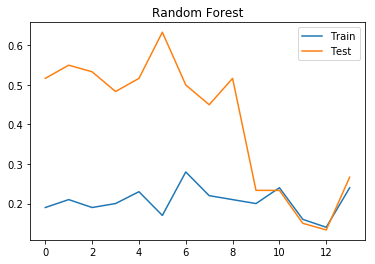

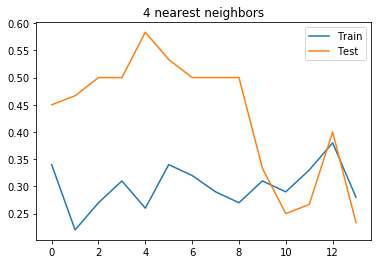

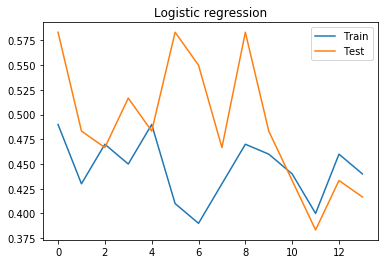

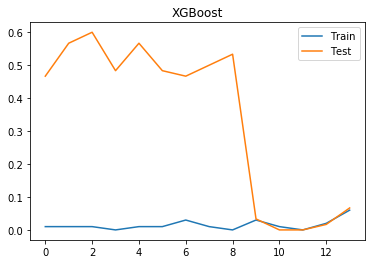

In [7]:
plt.plot(rando_train_err,label="Train")
plt.plot(rando_test_err,label="Test")
plt.title("Random Forest")
plt.legend()
plt.show()

plt.plot(knn_train_err,label="Train")
plt.plot(knn_test_err,label="Test")
plt.title("4 nearest neighbors")
plt.legend()
plt.show()

plt.plot(reg_train_err,label="Train")
plt.plot(reg_test_err,label="Test")
plt.title("Logistic regression")
plt.legend()
plt.show()

plt.plot(xgb_train_err,label="Train")
plt.plot(xgb_test_err,label="Test")
plt.title("XGBoost")
plt.legend()
plt.show()